# <font style="color:blue">LR Scheduler</font>

We know that decreasing the learning rate with epochs or after a few epochs does help in convergence. Thankfully, this can be done in PyTorch using the `torch.optim.lr_scheduler` class which changes the learning rate for the optimizer depending upon the type of scheduler chosen. 

In this notebook, we will see how to use different learning rate schedulers. 

We will use the "Fashion MNIST" dataset, and SGD optimizer with momentum to illustrate the convergence of different learning rate schedulers.

We will use the same LeNet architecture.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt  # one of the best graphics library for python
plt.style.use('ggplot')

In [3]:
import os
import time

from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from torch.optim import lr_scheduler

# <font style="color:blue">1. LeNet Architecture</font>

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=120, out_features=84), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        x = self._body(x)
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x

# <font style="color:blue">2. Display the Network</font>

In [5]:
lenet_model = LeNet()
print(lenet_model)

LeNet(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


# <font style="color:blue">3. Get Fashion MNIST Data</font>

In [6]:
def get_data(batch_size, data_root='data', num_workers=1):
    
    train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)),
        # this re-scales image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean (0.2860) and divide by variance (0.3530).
        # This mean and variance is calculated on training data (verify for yourself)
        transforms.Normalize((0.2860, ), (0.3530, ))
    ])
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=True, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

# <font style="color:blue">4. System Configuration</font>

In [7]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

# <font style="color:blue">5. Training Configuration</font>

In [8]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 50  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.01  # determines the speed of network's weights update
    log_interval: int = 500  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "./data"  # folder to save Fashion MNIST data (default: data)
    num_workers: int = 10  # number of concurrent processes used to prepare data
    device: str = 'cuda'  # device to use for training.
    


# <font style="color:blue">6. System Setup</font>

In [9]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

# <font style="color:blue">7. Training</font>
We are familiar with the training pipeline used in PyTorch.

In [10]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mode
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (it is mandatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gradients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

#         if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
#             print(
#                 'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
#                     epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
#                 )
#             )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    
    print('\nEpoch: {} Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))

    return epoch_loss, epoch_acc

# <font style="color:blue">8. Validation</font>

In [11]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

# <font style="color:blue">9. Main</font>

Most of the code in this section is similar to what you have already seen in previous sections. The only change is that when we use the `ReduceLROnPlateau` Scheduler, we use the train_loss as a metric to monitor and reduce the learning rate.


In [12]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epoch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        
        # scheduler step/ update learning rate
        if scheduler is not None:
            if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_loss)
                print("Bad Epochs:{}".format(scheduler.num_bad_epochs))
                print("last LR = {}".format(scheduler._last_lr))
            else:
                scheduler.step()
            
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

# <font style="color:blue">10. Training using SGD Momentum without LR Scheduler</font>

```
torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)
```

The default value of momentum is `0`, we should change it to `0.9`.

Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [13]:
model = LeNet()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=train_config.learning_rate,
    momentum = 0.9
)


model, train_loss_sgd_momentum, train_acc_sgd_momentum, test_loss_sgd_momentum, test_acc_sgd_momentum = main(
    model, 
    optimizer)



100%|██████████| 26421880/26421880 [00:03<00:00, 7165256.52it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 2094101.13it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6856015.38it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5148373.15it/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw


Epoch: 0 Loss: 0.532281 Acc: 0.8026
Elapsed 27.49s, 27.49 s/epoch, 0.01 s/batch, ets 1346.93s

Epoch: 1 Loss: 0.348889 Acc: 0.8719
Elapsed 61.35s, 30.67 s/epoch, 0.01 s/batch, ets 1472.38s

Epoch: 2 Loss: 0.308323 Acc: 0.8867
Elapsed 93.97s, 31.32 s/epoch, 0.01 s/batch, ets 1472.23s

Epoch: 3 Loss: 0.292068 Acc: 0.8917
Elapsed 127.70s, 31.92 s/epoch, 0.01 s/batch, ets 1468.50s

Epoch: 4 Loss: 0.272289 Acc: 0.8994
Elapsed 162.67s, 32.53 s/epoch, 0.01 s/batch, ets 1463.99s

Epoch: 5 Loss: 0.261487 Acc: 0.9037
Elapsed 198.02s, 33.00 s/epoch, 0.01 s/batch, ets 1452.12s

Epoch: 6 Loss: 0.252595 Acc: 0.9053
Elapsed 248.24s, 35.46 s/epoch, 0.01 s/batch, ets 1524.88s

Epoch: 7 Loss: 0.244465 Acc: 0.9090
Elapsed 325.62s, 40.70 s/epoch, 0.01 s/batch, ets 1709.49s

Epoch: 8 Loss: 0.236150 Acc: 0.9121
Elapsed 393.31s, 43.70 s/epoch, 0.01 s/batch, ets 1791.77s

Epoch: 9 Loss: 0.233448 Acc: 0.9115
Elapsed 419.9

# <font style="color:blue">11. Training with Learning Rate Scheduler</font>


## <font style="color:green">11.1. Time Based (MultiplicativeLR)</font>

$$
\alpha = \frac{\alpha_0}{1 + \gamma n} 
$$

where, $\alpha_0 = \text{inital learning rate} $

$\gamma = \text{decay_rate}$

$n = \text{epoch}$

**MultiplicativeLR method in PyTorch:**

```
torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda, last_epoch=-1)
```

- `optimizer` (Optimizer) – Wrapped optimizer.

- `lr_lambda` (function or list) – A function which computes a multiplicative factor given an integer parameter epoch, or a list of such functions, one for each group in optimizer.param_groups.

- `last_epoch` (python:int) – The index of last epoch. Default: -1.

Details find [here](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.MultiplicativeLR).


In [14]:
model = LeNet()

init_learning_rate = 0.02

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr = init_learning_rate,
    momentum = 0.9
)

decay_rate = 0.5
lmbda = lambda epoch: 1/(1 + decay_rate * epoch)

scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)


model, train_loss_time_based, train_acc_time_based, test_loss_time_based, test_acc_time_based = main(
    model, 
    optimizer, 
    scheduler)




Epoch: 0 Loss: 0.551097 Acc: 0.7959
Elapsed 19.62s, 19.62 s/epoch, 0.01 s/batch, ets 961.36s

Epoch: 1 Loss: 0.357846 Acc: 0.8652
Elapsed 42.87s, 21.44 s/epoch, 0.01 s/batch, ets 1028.90s

Epoch: 2 Loss: 0.304882 Acc: 0.8846
Elapsed 69.22s, 23.07 s/epoch, 0.01 s/batch, ets 1084.38s

Epoch: 3 Loss: 0.274805 Acc: 0.8961
Elapsed 149.74s, 37.43 s/epoch, 0.01 s/batch, ets 1721.96s

Epoch: 4 Loss: 0.249684 Acc: 0.9049
Elapsed 181.38s, 36.28 s/epoch, 0.01 s/batch, ets 1632.40s

Epoch: 5 Loss: 0.229304 Acc: 0.9120
Elapsed 203.07s, 33.85 s/epoch, 0.01 s/batch, ets 1489.18s

Epoch: 6 Loss: 0.211720 Acc: 0.9183
Elapsed 225.78s, 32.25 s/epoch, 0.01 s/batch, ets 1386.92s

Epoch: 7 Loss: 0.198907 Acc: 0.9217
Elapsed 257.54s, 32.19 s/epoch, 0.01 s/batch, ets 1352.06s

Epoch: 8 Loss: 0.184792 Acc: 0.9292
Elapsed 309.59s, 34.40 s/epoch, 0.01 s/batch, ets 1410.38s

Epoch: 9 Loss: 0.172465 Acc: 0.9333
Elapsed 341.60s, 34.16 s/epoch, 0.01 s/batch, ets 1366.42s

Epoch: 10 Loss: 0.161832 Acc: 0.9366
Elapse

## <font style="color:green">11.2. Step Decay (StepLR)</font>

$$
\alpha = \alpha_0 * \gamma^{\lfloor\frac{n}{s}\rfloor}
$$

where, $\alpha_0 = \text{inital learning rate} $

$n = \text{epoch}$

$\gamma = \text{decay_rate}$

$s = \text{step_size}$

**StepLR method:**

```
torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.1, last_epoch=-1)
```
- `optimizer` (Optimizer) – Wrapped optimizer.

- `step_size` (python:int) – Period of learning rate decay.

- `gamma` (python:float) – Multiplicative factor of learning rate decay. Default: `0.1`.

- `last_epoch` (python:int) – The index of last epoch. Default: `-1`.

Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR).

In [15]:
model = LeNet()

init_learning_rate = 0.02

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr = init_learning_rate,
    momentum = 0.9
)

step_size = 10

decay_rate = 0.5

scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=decay_rate)


model, train_loss_step_decay, train_acc_step_decay, test_loss_step_decay, test_acc_step_decay = main(
    model, 
    optimizer, 
    scheduler)


Epoch: 0 Loss: 0.551097 Acc: 0.7959
Elapsed 1609.44s, 1609.44 s/epoch, 0.43 s/batch, ets 78862.49s

Epoch: 1 Loss: 0.400184 Acc: 0.8524
Elapsed 1640.31s, 820.15 s/epoch, 0.22 s/batch, ets 39367.40s

Epoch: 2 Loss: 0.378177 Acc: 0.8623
Elapsed 1669.92s, 556.64 s/epoch, 0.15 s/batch, ets 26162.03s

Epoch: 3 Loss: 0.366674 Acc: 0.8664
Elapsed 1699.83s, 424.96 s/epoch, 0.11 s/batch, ets 19548.00s

Epoch: 4 Loss: 0.355135 Acc: 0.8725
Elapsed 1728.51s, 345.70 s/epoch, 0.09 s/batch, ets 15556.58s

Epoch: 5 Loss: 0.348526 Acc: 0.8729
Elapsed 1757.49s, 292.91 s/epoch, 0.08 s/batch, ets 12888.23s

Epoch: 6 Loss: 0.355011 Acc: 0.8721
Elapsed 1786.05s, 255.15 s/epoch, 0.07 s/batch, ets 10971.46s

Epoch: 7 Loss: 0.349803 Acc: 0.8748
Elapsed 1815.32s, 226.91 s/epoch, 0.06 s/batch, ets 9530.43s

Epoch: 8 Loss: 0.341063 Acc: 0.8755
Elapsed 1843.43s, 204.83 s/epoch, 0.05 s/batch, ets 8397.84s

Epoch: 9 Loss: 0.352920 Acc: 0.8754
Elapsed 1868.88s, 186.89 s/epoch, 0.05 s/batch, ets 7475.52s

Epoch: 10 L

## <font style="color:green">11.3. Exponential Decay (ExponentialLR)</font>

$$
\alpha = \alpha_0 * \gamma^n
$$

where, $\alpha_0 = \text{inital learning rate} $

$n = \text{epoch}$

$\gamma = \text{decay_rate}$

**ExponentialLR method:**

```
torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)
```
- `optimizer` (Optimizer) – Wrapped optimizer.

- `gamma` (python:float) – Multiplicative factor of learning rate decay.

- `last_epoch` (python:int) – The index of last epoch. Default: -1.

Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ExponentialLR).

In [16]:
model = LeNet()

init_learning_rate = 0.02

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr = init_learning_rate,
    momentum = 0.9
)


decay_rate = 0.9

scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)


model, train_loss_exp_decay, train_acc_exp_decay, test_loss_exp_decay, test_acc_exp_decay = main(
    model, 
    optimizer, 
    scheduler)


Epoch: 0 Loss: 0.551097 Acc: 0.7959
Elapsed 23.09s, 23.09 s/epoch, 0.01 s/batch, ets 1131.22s

Epoch: 1 Loss: 0.384632 Acc: 0.8574
Elapsed 44.17s, 22.09 s/epoch, 0.01 s/batch, ets 1060.11s

Epoch: 2 Loss: 0.345396 Acc: 0.8706
Elapsed 68.02s, 22.67 s/epoch, 0.01 s/batch, ets 1065.70s

Epoch: 3 Loss: 0.319116 Acc: 0.8811
Elapsed 96.20s, 24.05 s/epoch, 0.01 s/batch, ets 1106.33s

Epoch: 4 Loss: 0.293917 Acc: 0.8896
Elapsed 124.66s, 24.93 s/epoch, 0.01 s/batch, ets 1121.94s

Epoch: 5 Loss: 0.273496 Acc: 0.8979
Elapsed 153.86s, 25.64 s/epoch, 0.01 s/batch, ets 1128.30s

Epoch: 6 Loss: 0.255902 Acc: 0.9029
Elapsed 181.36s, 25.91 s/epoch, 0.01 s/batch, ets 1114.04s

Epoch: 7 Loss: 0.239390 Acc: 0.9098
Elapsed 209.39s, 26.17 s/epoch, 0.01 s/batch, ets 1099.28s

Epoch: 8 Loss: 0.221791 Acc: 0.9155
Elapsed 236.53s, 26.28 s/epoch, 0.01 s/batch, ets 1077.54s

Epoch: 9 Loss: 0.207662 Acc: 0.9195
Elapsed 264.52s, 26.45 s/epoch, 0.01 s/batch, ets 1058.10s

Epoch: 10 Loss: 0.193213 Acc: 0.9246
Elapse

## <font style="color:green">11.4. ReduceLROnPlateau</font>

This is the most interesting scheduler. In all the above LR-schedulers, reducing strategy is already defined. So it is a matter of experience and experiments to find the right hyperparameters of LR-scheduler. `ReduceLROnPlateeau` does solve this problem.

For the given number of epochs, if the model does not improve, it reduces the learning rate.

**ReduceLROnPlateau method:**

```
torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
```
- `optimizer` (Optimizer) – Wrapped optimizer.

- `mode` (str) – One of min, max. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; in max mode it will be reduced when the quantity monitored has stopped increasing. Default: ‘min’.

- `factor` (python:float) – Factor by which the learning rate will be reduced. `new_lr = lr * factor`. Default: `0.1`.

- `patience` (python:int) – Number of epochs with no improvement after which learning rate will be reduced. For example, if patience = 2, then we will ignore the first 2 epochs with no improvement, and will only decrease the LR after the 3rd epoch if the loss still hasn’t improved then. Default: `10`.

- `verbose` (bool) – If True, prints a message to stdout for each update. Default: False.

- `threshold` (python:float) – Threshold for measuring the new optimum, to only focus on significant changes. Default: `1e-4`.

- `threshold_mode` (str) – One of rel, abs. In rel mode, dynamic_threshold = best * ( 1 + threshold ) in ‘max’ mode or best * ( 1 - threshold ) in min mode. In abs mode, dynamic_threshold = best + threshold in max mode or best - threshold in min mode. Default: ‘rel’.

- `cooldown` (python:int) – Number of epochs to wait before resuming normal operation after lr has been reduced. Default: `0`.

- `min_lr` (python:float or list) – A scalar or a list of scalars. A lower bound on the learning rate of all param groups or each group respectively. Default: `0`.

- `eps` (python:float) – Minimal decay applied to lr. If the difference between new and old lr is smaller than eps, the update is ignored. Default: 1e-8.

Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau)


We have configured the scheduler as follows:
1. We will use `train_loss` as a metric to watch if it stagnates.
1. We keep `threshold` to `0.1`. So, we will watch out for change in the first decimal, i.e. redule LR if the change consecutive epochs have difference of 0.1.
1. We will keep `patience` at `5` epochs which means we will wait for 5 epochs before changing the learning rate.

In [17]:
model = LeNet()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=train_config.learning_rate,
    momentum = 0.9
)

factor = 0.3  # reduce by factor 0.5
patience = 2  # epochs
threshold = 0.1
verbose = True

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience, verbose=verbose, threshold=threshold)


model, train_loss_plateau, train_acc_plateau, test_loss_plateau, test_acc_plateau = main(
    model, 
    optimizer, 
    scheduler)

c:\Users\dirk.adler\AppData\Local\anaconda3\envs\tensorflow\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



Epoch: 0 Loss: 0.543794 Acc: 0.7969
Elapsed 19.96s, 19.96 s/epoch, 0.01 s/batch, ets 977.90s
Bad Epochs:0
last LR = [0.01]

Epoch: 1 Loss: 0.363186 Acc: 0.8663
Elapsed 40.88s, 20.44 s/epoch, 0.01 s/batch, ets 981.08s
Bad Epochs:0
last LR = [0.01]

Epoch: 2 Loss: 0.322362 Acc: 0.8812
Elapsed 61.68s, 20.56 s/epoch, 0.01 s/batch, ets 966.38s
Bad Epochs:0
last LR = [0.01]

Epoch: 3 Loss: 0.303532 Acc: 0.8886
Elapsed 84.73s, 21.18 s/epoch, 0.01 s/batch, ets 974.40s
Bad Epochs:1
last LR = [0.01]

Epoch: 4 Loss: 0.285931 Acc: 0.8931
Elapsed 112.20s, 22.44 s/epoch, 0.01 s/batch, ets 1009.83s
Bad Epochs:0
last LR = [0.01]

Epoch: 5 Loss: 0.271481 Acc: 0.8990
Elapsed 167.16s, 27.86 s/epoch, 0.01 s/batch, ets 1225.84s
Bad Epochs:1
last LR = [0.01]

Epoch: 6 Loss: 0.261286 Acc: 0.9020
Elapsed 203.52s, 29.07 s/epoch, 0.01 s/batch, ets 1250.19s
Bad Epochs:2
last LR = [0.01]

Epoch: 7 Loss: 0.251398 Acc: 0.9059
Elapsed 227.35s, 28.42 s/epoch, 0.01 s/batch, ets 1193.57s
Bad Epochs:0
last LR = [0.01]


# <font style="color:blue">12. Loss Plot</font>

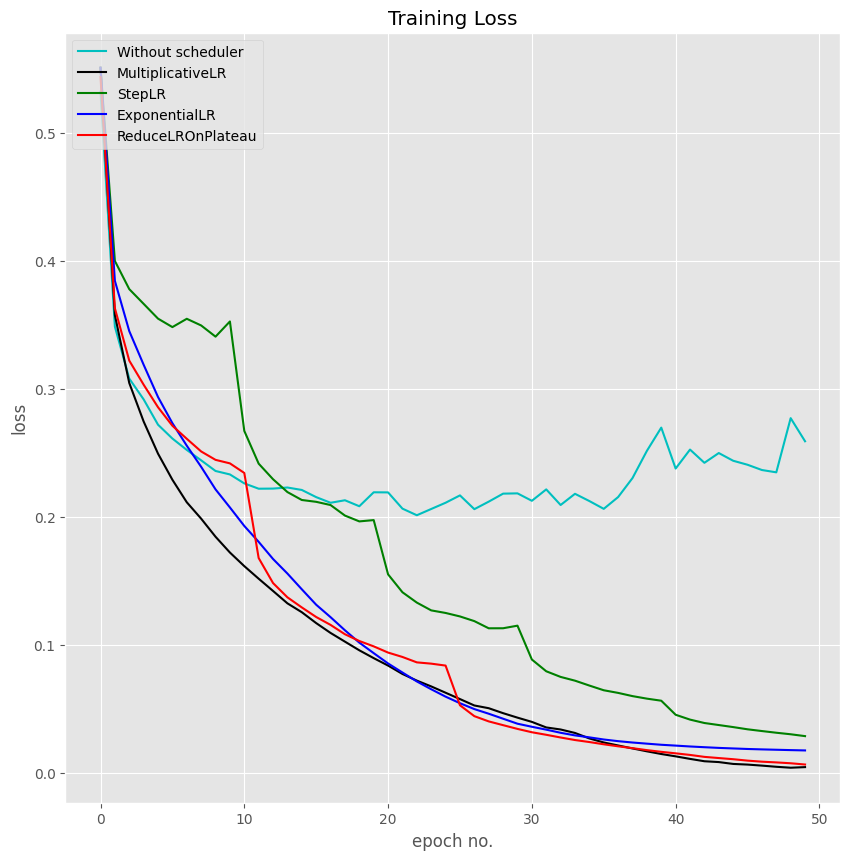

In [18]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 10)
x = range(len(train_loss_sgd_momentum))

plt.figure


plt.plot(x, train_loss_sgd_momentum, 'c', label="Without scheduler")

plt.plot(x, train_loss_time_based, 'k', label="MultiplicativeLR")

plt.plot(x, train_loss_step_decay, 'g', label="StepLR")

plt.plot(x, train_loss_exp_decay, 'b', label="ExponentialLR")

plt.plot(x, train_loss_plateau, 'r', label="ReduceLROnPlateau")

plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.title('Training Loss')
plt.show()

# <font style="color:blue">Conclusion</font>
We saw the various LR Schedulers in action, but practically there is no one-size-fits-all LR Scheduler which works for any problem. Ideally you should run multiple experiments with different LR schedulers to find the best model. 

For example, when you are solving a new problem, you won't know what is the actual loss which gives best results or what is the best loss you can get with your model and data. So, you can run some experiments using StepLR/others and you might see that the loss has decreased substantially (say the loss is varying around 0.035 to 0.038. However, you feel it can decrease further. So, try with the ReduceLROnPlateau Scheduler with a threshold that you feel might be right after doing the previous experiment (say 0.005) which means that if it stays in 0.35 to 0.38 range, you should decrease the LR.